### 零、首先安装依赖

In [2]:
!python -m spacy download en_core_web_sm
!pip install spacy
!pip install rouge
!pip install nltk
!pip install torch torchvision
!pip install tqdm
!pip install matplotlib
!pip install tensorboard

^C

Aborted!

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


### 一、导入模块

由于数据集、词表、评估标准当中在两个实验中有很多共用的地方，故编写在`datasets.py`,`vocabualary.py`和`metrics.py`中，不在notebook中体现。

In [12]:
from datetime import datetime, timedelta
import os
from PIL import Image

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn as nn

from datasets import ImageTextDataset
from vocabulary import Vocabulary
from metrics import bleu, meteor, rouge_l

### 二、定义模型结构

In [4]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, out_dim):
        """
        CNN图像编码器，得到图像整体特征
        :param out_dim: 输出特征维度
        :param in_channels: 图像通道数
        """
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        out_shape = (256, 8, 8)  # 根据实际输出尺寸进行调整
        self.fc = nn.Linear(in_features=out_shape[0] * out_shape[1] * out_shape[2], out_features=out_dim)

    def forward(self, x):
        x = self.conv_layers(x)  # (batch, 128, 8, 8)
        x = x.view(x.size(0), -1)  # Flatten, (batch, 128*8*8)
        x = self.fc(x)
        return x  # (batch, out_dim)


class ImageTextModel(nn.Module):
    """
    CNN做图像编码器，得到整体特征；LSTM做文本解码器，输出图像描述序列
    """

    def __init__(self, vocabulary_size, in_channels, image_embed_dim, text_embed_dim, hidden_size=256,
                 pretrained_embeddings=None):
        super(ImageTextModel, self).__init__()

        self.image_embed = ConvNet(in_channels, image_embed_dim)  # CNN整体表示

        if pretrained_embeddings is not None:
            assert pretrained_embeddings.shape == (vocabulary_size, text_embed_dim), "预训练嵌入向量尺寸不匹配"
            self.text_embed = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embeddings), freeze=False)
        else:
            self.text_embed = nn.Embedding(vocabulary_size, text_embed_dim)

        self.lstm = nn.LSTM(image_embed_dim + text_embed_dim, hidden_size, num_layers=2, batch_first=True)

        self.fc_out = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, images, seq, hidden_state: tuple = None, image_feats=None):
        """
        将图像整体特征嵌入与拼接到序列的每一个时间步上，构成RNN的原始输入
        :param images: (batch, channels, img_size, img_size)
        :param seq: (batch, seq_len)
        :param hidden_state: RNN（LSTM）隐含状态: (h, c)
        :param image_feats: 图像特征
        :return:
        """
        if image_feats is None:
            image_feats = self.image_embed(images)  # (batch, image_embed_dim)

        image_embed = image_feats.unsqueeze(1).repeat(1, seq.size(1), 1)  # (batch, seq_len, image_embed_dim)

        text_embed = self.text_embed(seq)  # (batch, seq_len, text_embed_dim)
        embeddings = torch.cat((image_embed, text_embed), dim=2)  # -> (batch, seq_len, text_embed_dim+image_embed_dim)

        lstm_output, hidden_state = self.lstm(embeddings, hidden_state)  # (batch, seq_len, hidden_size)

        output = self.fc_out(lstm_output)  # (batch, seq_len, vocabulary_size)
        return output, (hidden_state, image_feats)

### 三、定义训练、预测和验证函数

In [5]:

def train(model, train_loader, criterion, optimizer, save_path, device, epochs=10,
          save_interval=120, pretrained_weights=None, experiment_name='experiment'):
    writer = SummaryWriter(f'runs/{experiment_name}')

    os.makedirs(os.path.split(save_path)[0], exist_ok=True)

    if pretrained_weights:
        model.load_state_dict(torch.load(pretrained_weights))

    # training loop
    p_bar = tqdm(range(epochs))
    model = model.to(device)
    save_interval = timedelta(seconds=save_interval)
    model.train()

    for epoch in p_bar:
        running_loss = 0.0

        last_save_time = datetime.now()
        for batch_idx, (image, seq, seq_len) in enumerate(train_loader):
            image = image.to(device)  # (batch, c, img_sz, img_sz)
            seq = seq.to(device)  # (batch, seq_len + 1)

            input_seq = seq[:, :-1]  # (batch, seq_len)
            target_seq = seq[:, 1:]  # (batch, seq_len)

            optimizer.zero_grad()
            prediction, _ = model(image, input_seq)  # (batch, seq_len - 1, vocabulary_size)
            _, _, vocab_size = prediction.shape
            loss = criterion(prediction.view(-1, vocab_size), target_seq.contiguous().view(-1))
            loss.backward()
            optimizer.step()

            # autosave
            if datetime.now() - last_save_time > save_interval:
                last_save_time = datetime.now()
                torch.save(model.state_dict(), save_path)

            # 记录结果
            running_loss += loss.item()
            p_bar.set_postfix(progress=f'{(batch_idx + 1)} / {len(train_loader)}',
                              loss=f'{running_loss / (batch_idx + 1):.4f}',
                              last_save_time=last_save_time)
            writer.add_scalar('Loss/train', running_loss / (batch_idx + 1), epoch * len(train_loader) + batch_idx)

    writer.close()


def predict_greedy(model, image, transform, vocab, device, max_length):
    """
    事实上，beam_width=1的束搜索等价于贪心算法
    """
    model.to(device)
    image = transform(image).unsqueeze(0).to(device)  # -> (1, channel, img_size, img_size)
    seq = [vocab.start]

    h = ()
    for _ in range(max_length):
        with torch.no_grad():
            inp = torch.tensor([seq[-1]], dtype=torch.long, device=device).unsqueeze(0)
            output, h = model(image, inp, *h)

        predicted = output.argmax(2)[:, -1]
        seq.append(predicted.item())
        if predicted.item() == vocab.end:
            break

    return vocab.decode(seq)


def generate_by_beam_search(model, image, vocab, device, max_length, beam_width=5):
    """
    使用束搜索生成序列
    """
    model.to(device)
    image = image.to(device)  # (1, channel, img_size, img_size)

    # 初始候选序列和分数
    sequences = [([vocab.start], 0, ())]  # 每个序列是(token_list, score, h)

    for _ in range(max_length):
        all_candidates = []
        for seq, score, h in sequences:
            if seq[-1] == vocab.end:
                all_candidates.append((seq, score, h))
                continue

            inp = torch.tensor([seq[-1]], dtype=torch.long, device=device).unsqueeze(0)
            with torch.no_grad():
                output, h_ = model(image, inp, *h)  # 假设model返回单个输出

            # 考虑top k个候选
            top_k_probs, top_k_indices = torch.topk(torch.softmax(output, dim=-1), beam_width, dim=-1)
            top_k_probs = top_k_probs[0, -1]
            top_k_indices = top_k_indices[0, -1]

            for k in range(beam_width):
                next_seq = seq + [top_k_indices[k].item()]
                next_score = score - torch.log(top_k_probs[k])  # 使用负对数似然作为分数
                all_candidates.append((next_seq, next_score, h_))

        # 按分数排序并选出前k个
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    # 选择分数最高的序列
    best_seq = sequences[0][0]
    best_score = sequences[0][1].item()
    return vocab.decode(best_seq), best_score


def evaluate(model, test_set, vocabulary, device, max_length, beam_width=5):
    """评估模型性能"""
    model.eval()
    metrics = np.zeros(4)
    p_bar = tqdm(range(len(test_set)), desc='evaluating')
    for i in p_bar:
        _, caption = test_set.get_pair(i)
        image, _, _ = test_set[i]
        caption_generated, score = generate_by_beam_search(model, image.unsqueeze(0), vocabulary, device, max_length,
                                                              beam_width)
        metrics += np.array([score,
                             bleu(caption_generated, caption, vocabulary),
                             rouge_l(caption_generated, caption, vocabulary),
                             meteor(caption_generated, caption, vocabulary)])
        value = metrics / (i + 1)
        p_bar.set_postfix(score=value[0], bleu=value[1], rouge_l=value[2], meteor=value[3])

### 四、模型训练和结构超参数

In [6]:
# =========== Example parameters for the model ===========
img_size = 256  # Size of the input image
in_channels = 3  # Number of input channels (for RGB images)
text_emb_size = 96  # Text Embedding size
img_emb_size = 64  # Image Embedding size
hidden_size = 256  # LSTM Hiddem size
dropout = 0.1  # Dropout rate
lr = 5e-4  # Learning rate
epochs = 500  # train epochs
batch_size = 64  # Batch size
seq_length = 128  # Max length of the caption sequence
save_path = 'models/model_lstm.pth'
experiment_name = 'fashion_description_lstm'
vocabulary_path = 'vocabulary/vocab.json'
word2vec_cache_path = 'vocabulary/word2vec.npy'
dataset_root = 'data/deepfashion-multimodal'
train_labels_path = 'data/deepfashion-multimodal/train_captions.json'
test_labels_path = 'data/deepfashion-multimodal/test_captions.json'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### 五、构建词表，图像预处理变换

In [7]:
# ==================== Build Vocabulary ====================

vocabulary = Vocabulary(vocabulary_path)

# ==================== Define image transforms ====================

transform = Compose([
    Resize((img_size, img_size)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### 六、初始化/加载模型、数据集

In [8]:
# ==================== Initialize the model ====================
model = ImageTextModel(len(vocabulary), in_channels, img_emb_size, text_emb_size, hidden_size,
                       pretrained_embeddings=vocabulary.get_word2vec(cache_path=word2vec_cache_path)).to(device)

if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path))

### 七、开始训练

In [9]:
# ==================== Prepare for training ====================
train_set = ImageTextDataset(dataset_root,
                             train_labels_path,
                             vocabulary=vocabulary,
                             max_seq_len=seq_length,
                             transform=transform,
                             max_cache_memory=32 * 1024 ** 3)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# =================== Start Training ===================
train(model, train_loader, criterion, optimizer,
      save_path=save_path,
      device=device,
      epochs=epochs,
      experiment_name=experiment_name)

  0%|          | 0/500 [00:10<?, ?it/s, last_save_time=2023-12-27 02:17:52.011862, loss=0.3171, progress=8 / 159]


KeyboardInterrupt: 

### 八、模型推理和评估

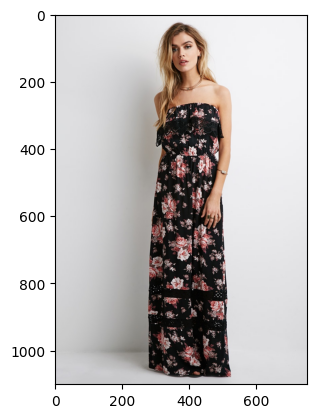

caption:  Her tank shirt has no sleeves, cotton fabric and floral patterns. The trousers the female wears is of long length. The trousers are with cotton fabric and floral patterns. There is an accessory on her wrist. There is an accessory in his her neck. This woman is wearing a ring on her finger. 

generated:  The upper clothing has long sleeves, cotton fabric and solid color patterns. The neckline of it is crew. The lower clothing is of long length. The fabric is cotton and it has pure color patterns. There is an accessory on her wrist. 

best score: 20.073341369628906
bleu score:  0.3121712400413416
rouge-l score:  0.5396825348349711
meteor score:  0.6614583333333331


In [13]:
#  =================== Model Inference ===================
test_set = ImageTextDataset(dataset_root,
                            test_labels_path,
                            vocabulary=vocabulary,
                            max_seq_len=seq_length,
                            transform=transform,
                            max_cache_memory=32 * 1024 ** 3)

image_path, caption = test_set.sample()
original_image = Image.open(image_path)
image = transform(original_image).unsqueeze(0)
caption_generated, score = generate_by_beam_search(model, image, vocabulary, device, seq_length,
                                                   beam_width=5)

plt.imshow(original_image)
plt.show()

print('caption: ', caption, '\n\ngenerated: ', caption_generated, '\n')
print(f'best score: {score}')  # 序列全概率的负对数似然, 越小越好
print('bleu score: ', bleu(caption_generated, caption, vocabulary))
print('rouge-l score: ', rouge_l(caption_generated, caption, vocabulary))
print('meteor score: ', meteor(caption_generated, caption, vocabulary))

### 九、在整个测试集上评估

In [14]:
evaluate(model, test_set, vocabulary, device, seq_length, beam_width=5)

evaluating:   1%|          | 24/2538 [00:03<06:29,  6.45it/s, bleu=0.241, meteor=0.659, rouge_l=0.525, score=20.1]/home/hammer/Documents/PycharmProjects/FashionDescription/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
evaluating:  58%|█████▊    | 1461/2538 [04:05<03:01,  5.94it/s, bleu=0.258, meteor=0.659, rouge_l=0.535, score=20.1]/home/hammer/Documents/PycharmProjects/FashionDescription/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_m